# 2 Comparing Gesture Recognizers

In [86]:
from matplotlib import pyplot as plt
import numpy as np
import os
import time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from scipy.signal import resample
import xml.etree.ElementTree as ET
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 50

In [44]:
def load_data(folder, subfolder):
    data = []

    for root, subdirs, files in os.walk(folder):
        if 'ipynb_checkpoint' in root:
            continue

        if len(files) > 0:
            for f in tqdm(files):
                if '.xml' in f:
                    fname = f.split('.')[0]
                    label = fname[:-2]

                    xml_root = ET.parse(f'{subfolder}{root}/{f}').getroot()

                    points = []
                    for element in xml_root.findall('Point'):
                        x = element.get('X')
                        y = element.get('Y')
                        points.append([x, y])

                    points = np.array(points, dtype=float)

                    scaler = StandardScaler()
                    points = scaler.fit_transform(points)

                    resampled = resample(points, NUM_POINTS)

                    data.append((label, resampled))
    return data

In [45]:
#train_data = load_data('xml_logs', 'dataset/')
test_data = load_data('dataset', '')

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

In [46]:
def prepare_data(data):
    labels = [sample[0] for sample in data]

    print(set(labels))

    encoder = LabelEncoder()
    labels_encoded = encoder.fit_transform(labels)

    print(set(labels_encoded))

    y = to_categorical(labels_encoded)

    print(len(y[0]))

    sequences = [sample[1] for sample in data]
    X = np.array(sequences)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    return X_train, X_test, y_train, y_test, labels

In [47]:
X_train, X_test, y_train, y_test, labels = prepare_data(test_data)

{'left_sq_bracket', 'pigtail', 'delete_mark', 'right_curly_brace', 'right_sq_bracket', 'question_mark', 'v', 'caret', 'x', 'check', 'rectangle', 'circle', 'star', 'arrow', 'triangle', 'zig-zag', 'left_curly_brace'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
17
(4352, 50, 2) (1088, 50, 2) (4352, 17) (1088, 17)


In [48]:
def create_model(X_train, X_test, y_train, y_test, labels, num_parameters):
    # Define the model
    model = Sequential()

    # add LSTM layer
    # input shape is (length of an individual sample, dimensions of the sample)
    # in our case: two dimensions, as we have X and Y coordinates
    model.add(LSTM(num_parameters, input_shape=(NUM_POINTS, 2)))

    # add dense layer to do machine learning magic
    model.add(Dense(32, activation='relu'))

    # here, you can add more layers and maybe a dropout for better performance

    # softmax layer for classification
    model.add(Dense(len(set(labels)), activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)
    
    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[reduce_lr, stop_early]
    )
    
    model.summary()
    
    return model, history

In [54]:
model_64, history_64 = create_model(X_train, X_test, y_train, y_test, labels, 64)
model_32, history_32 = create_model(X_train, X_test, y_train, y_test, labels, 32)
model_16, history_16 = create_model(X_train, X_test, y_train, y_test, labels, 16)
model_8, history_8 = create_model(X_train, X_test, y_train, y_test, labels, 8)

Epoch 1/20
136/136 [==============================] - 7s 28ms/step - loss: 1.5772 - accuracy: 0.5630 - val_loss: 0.6441 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 2/20
136/136 [==============================] - 5s 36ms/step - loss: 0.4078 - accuracy: 0.9092 - val_loss: 0.2852 - val_accuracy: 0.9430 - lr: 0.0010
Epoch 3/20
136/136 [==============================] - 5s 38ms/step - loss: 0.2269 - accuracy: 0.9501 - val_loss: 0.2221 - val_accuracy: 0.9421 - lr: 0.0010
Epoch 4/20
136/136 [==============================] - 5s 33ms/step - loss: 0.1649 - accuracy: 0.9554 - val_loss: 0.1678 - val_accuracy: 0.9504 - lr: 0.0010
Epoch 5/20
136/136 [==============================] - 5s 37ms/step - loss: 0.1281 - accuracy: 0.9632 - val_loss: 0.1391 - val_accuracy: 0.9596 - lr: 0.0010
Epoch 6/20
136/136 [==============================] - 4s 26ms/step - loss: 0.1157 - accuracy: 0.9685 - val_loss: 0.1161 - val_accuracy: 0.9632 - lr: 0.0010
Epoch 7/20
136/136 [==============================] - 5s 37ms/st

In [82]:
def plot_loss_accuracy(histories):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    colors = ["blue", "orange", "green", "red"]
    count = 0
    
    for history in histories:
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        
        color = colors[count]

        axs[0, 0].plot(accuracy, color=color)
        axs[0, 1].plot(val_accuracy, color=color)
        axs[1, 0].plot(loss, '--', color=color, alpha=0.5)
        axs[1, 1].plot(val_loss, '--', color=color, alpha=0.5)
        
        axs[0, 0].set_title("Accuracy")
        axs[0, 1].set_title("Validation Accuracy")
        axs[1, 0].set_title("Loss")
        axs[1, 1].set_title("Validation Loss")
        
        count += 1
    
    #handles, labels = axs[0, 0].gca().get_legend_handles_labels()
    #fig.legend(handles, labels, loc='upper right')
    #plt.figlegend(lines, labels, loc = 'lower center', ncol=5, labelspacing=0.)
#     lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
#     lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#     fig.legend(lines, labels)
    #axs[1,1].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    import matplotlib.patches as mpatches

    red_8 = mpatches.Patch(color='red', label='8')
    green_16 = mpatches.Patch(color='green', label='16')
    orange_32 = mpatches.Patch(color='orange', label='32')
    blue_64 = mpatches.Patch(color='blue', label='64')
    plt.legend(handles=[red_8, green_16, orange_32, blue_64])

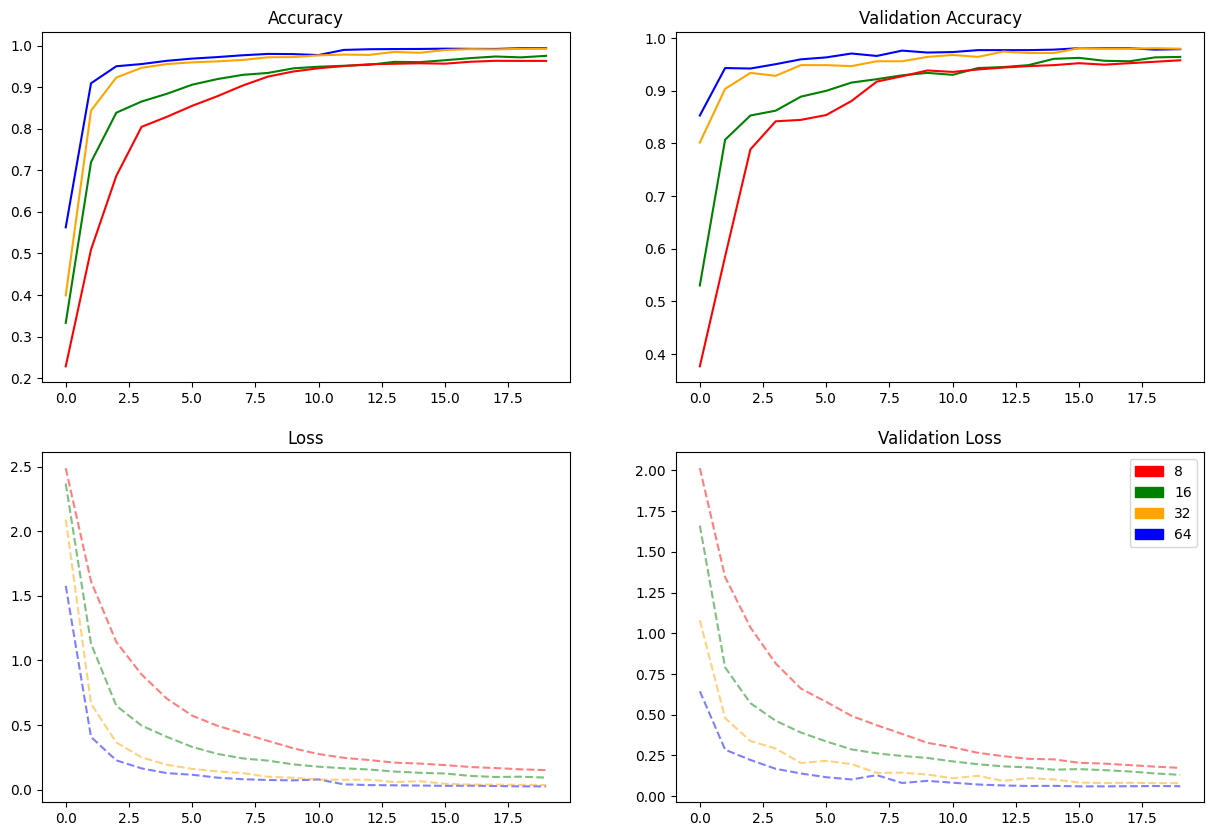

In [83]:
plot_loss_accuracy([history_64, history_32, history_16, history_8])

In [99]:
def evaluate_models(models):
    num_parameters = 64

    for model in models:
        score = model.evaluate(X_test, y_test, verbose=0)

        start_time = time.time()
        pred = model.predict(X_test, verbose = 0)
        stop_time = time.time()
        inference_time = stop_time - start_time
        
        print("LSTM with " + str(num_parameters) + " parameters:")
        print("Inference Time: ", inference_time)
        print("Accuracy: ", score[1], "\n")
        
        num_parameters = int(num_parameters / 2)

In [100]:
evaluate_models([model_64, model_32, model_16, model_8])

LSTM with 64 parameters:
Inference Time:  0.22714591026306152
Accuracy:  0.9788603186607361 

LSTM with 32 parameters:
Inference Time:  0.14401030540466309
Accuracy:  0.9797794222831726 

LSTM with 16 parameters:
Inference Time:  0.1297321319580078
Accuracy:  0.9641544222831726 

LSTM with 8 parameters:
Inference Time:  0.1345689296722412
Accuracy:  0.9577205777168274 



## Comparison of the models

Although there seems to be no big difference in the accuracy of the different models, the LSTM with 32 parameters could reach the best accuracy for this test data (ca. 0.98). If you want to compare inference times, the LSTM with 16 parameters performs best (ca. 0.13). Nevertheless, I would choose the LSTM with 32 parameters for a practical application due to its accuracy and inference time (inference time is only 0.015s higher than for the one with 16 parameters, but the accuracy is about a value of 0.015 better than this model).

## Comparison to the $1 Gesture Recognizer

As noted in the evaluation paper of the gesture recognizer (Wobbrock et al., 2007), the recognizer took 1.59 (SD=0.04) minutes on average. Recognition errors occured in 0.98% (SD=3.63), which results in an accuracy value of approximately 0.99. This was the result after training on recognition errors with 9 templates/training examples. However, with only 1 template, recognition errors occured in approximately 3%. <br>
Based on these results, I would tend to use a LSTM with 32 parameters for a practical application due to its significantly lower inference time. If you compare the accuracy results, there is no big difference between those models as the Gesture Recognizer had an accuracy of 0.97 in the worst case and 0.99 in the best case, while the LSTM was at 0.98. 

Reference: <br>
Wobbrock, J.O., Wilson, A.D. and Li, Y. (2007). Gestures without libraries, toolkits or training: A $1 recognizer for user interface prototypes. Proceedings of the ACM Symposium on User Interface Software and Technology (UIST '07). Newport, Rhode Island (October 7-10, 2007). New York: ACM Press, pp. 159-168.